**Transformer** Downscaling

Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.stats
import pandas as pd

import timeit
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from tensorflow import keras
from tensorflow.keras import layers

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


### Plotting Function

In [ ]:
def plotcompare(plotting, title, day_interval, FigName):          # plotting raw data
    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(plotting.index, plotting['prediction'],'--r')
    ax.plot(plotting.index, plotting['target'],'b')

    ax.xaxis.set(
        major_locator=mdates.DayLocator(interval=day_interval),
        major_formatter=mdates.DateFormatter("%d"))

    # HourLocator: Locate hours.
    # DayLocator: Locate specified days of the month.
    # WeekdayLocator: Locate days of the week, e.g., MO, TU.
    # MonthLocator: Locate months, e.g., 7 for July.
    # YearLocator: Locate years that are multiples of base.

    ax.set_title(title, fontsize=16, pad=14)
    ax.set_ylabel('Hs(m)' ,fontsize=16, labelpad=20)
    ax.set_xlabel('January 2020' ,fontsize=16, labelpad=20)
    ax.tick_params(labelsize=14)
    ax.set_xlim(plotting.index[0],plotting.index[len(plotting.index)-1])
    ax.legend(['Transformer','SWAN'], fontsize=14)
    ax.tick_params(labelsize=14)

    ax.grid(which='both', linestyle=':', linewidth=1)

    plt.tight_layout()
    plt.savefig(FigName, format='png', dpi=600)
    plt.show()


def plotLossHistory(loss,val_loss, FigName):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(np.arange(1,len(loss)+1,1), loss,'k')
    ax.plot(np.arange(1,len(val_loss)+1,1), val_loss,'--b')

    ax.set_xlim(1,len(loss))
    ax.tick_params(labelsize=14)
    ax.grid(which='both', linestyle=':', linewidth=1)

    ax.set_title('Model Loss', fontsize=16, pad=14)
    ax.set_ylabel('Loss' ,fontsize=16, labelpad=10)
    ax.set_xlabel('Epoch' ,fontsize=16, labelpad=10)

    plt.tight_layout()
    plt.savefig(FigName, format='png', dpi=600)
    plt.show()

def plotScatter(plotting, FigName):
    plt.figure(figsize=(6, 6))
    plt.xlabel('Actual',fontsize=14, labelpad=10)
    plt.ylabel('Prediction',fontsize=14, labelpad=10)
    plt.title('Actual vs Prediction', fontsize=16, pad=14)

    plt.plot(plotting['target'], plotting['prediction'], 'ro',fillstyle='none', markersize=6)
    plt.plot(np.arange(0,plotting.max().max()+plotting.mean().mean(),1).tolist())
    plt.tick_params(labelsize=14)
    plt.axis([plotting.min().min(), plotting.max().max(), plotting.min().min(), plotting.max().max()])

    plt.tight_layout()
    plt.savefig(FigName, format='png', dpi=600)

    plt.show()

### Data Preparation

In [ ]:
#Pembacaan data simulasi SWAN
df_swan = pd.read_csv('Wave Simulation/DATA_WAVE_01.csv')
#Mengubah data waktu simulasi SWAN ke datetime pandas
df_swan['Waktu'] = pd.to_datetime(df_swan['Waktu'])
#Membuat index pada data
df_swan = df_swan.set_index('Waktu')
df_swan.index.names = [None]
#Mengubah frequensi data menjadi setiap 3 jam sekali
df_swan = df_swan.asfreq('3H')
#Memilih data dari 2017 hingga 2020
df_swan = df_swan.loc['2011':'2020']

#Print data sample
print(df_swan.head(2))
print(df_swan.tail(2))

                       Hs    Tp  Tm01  Tm02   Mdir
2011-01-01 00:00:00  0.41  4.10  2.51  2.00  328.6
2011-01-01 03:00:00  0.50  4.33  2.68  2.18  330.3
                       Hs    Tp  Tm01  Tm02   Mdir
2020-12-31 18:00:00  0.43  4.44  3.07  2.48  339.4
2020-12-31 21:00:00  0.48  4.50  3.11  2.53  335.7


In [ ]:
def data_processing(time_start, time_end, location):
  #Pembacaan titik area global
  train_data_hold = []
  df_era_all = []
  location_input = location

  for i in range(len(location_input)):
      df_hold = pd.read_csv('Wave Global/DATA_METOCEAN_'+location_input[i]+'.csv')
      df_hold.index = pd.to_datetime(df_hold['Waktu'])
      df_hold = df_hold.loc[df_swan.index]

      df_hold = df_hold.fillna(0)
      train_data_hold.append(df_hold[['Hs']].loc[time_start:time_end])

  return train_data_hold

### Transformer

##### Transformer Model

In [ ]:
#encoder layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #Bagian Normalisasi dan Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    #Bagian Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
#bangun model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

##### Training Function

In [ ]:
#transformer model training
def transformer_model(train_data, target_train, val_data, target_val):
  #timer start
  start = timeit.default_timer()

  #parameter
  input_shape = train_data.shape[1:]

  model = build_model(
      input_shape,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.4,
      dropout=0.25,
  )

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4)
  )
  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, \
      restore_best_weights=True)]

  modelhist = model.fit(
      train_data,
      target_train,
      validation_data=(val_data, target_val),
      epochs=200,
      batch_size=64,
      callbacks=callbacks
  )

  model.evaluate(val_data, target_val, verbose=1)

  #timer stop
  stop = timeit.default_timer()
  comp_time = (stop - start)

  return model, modelhist, comp_time

##### Testing Function

In [ ]:
#model testing function
def model_testing(model, test_data, target_test, start, end, compare_name, scatter_name):
  pred   = model.predict(test_data, verbose=1).mean(axis=1).ravel()
  target = target_test.ravel()

  cc = scipy.stats.pearsonr(target.ravel(),pred)[0]
  rmse = np.sqrt(np.mean((pred-target.ravel())**2))
  mape = np.mean(np.abs((target.ravel() - pred) / target.ravel())) * 100

  print('Testing')
  print('Correlation Coefficient value is ', np.round(cc,3))
  print('RMSE value is ', np.round(rmse,3))
  print('MAPE value is ', np.round(mape,3))

  pred   = model.predict(test_data, verbose=1).mean(axis=1).ravel()
  plot_test = pd.DataFrame(index=df_swan.loc[start:end].index,data=np.array([pred,target]).T, columns=['prediction','target'])
  plotting = plot_test

  # plotting = plot_test.loc['2022-03-16':'2022-05']
  plotcompare(plotting,'Testing Data',1,compare_name)
  plotScatter(plotting,scatter_name)

### Discussion

#### Spatial Correlation

##### Preparation

In [ ]:
c = []
location_input = np.loadtxt("Global Point.txt", dtype=str)

for i in range(len(location_input)):
    df_hold = pd.read_csv('Wave Global/DATA_METOCEAN_'+location_input[i]+'.csv')
    df_hold.index = pd.to_datetime(df_hold['Waktu'])
    df_hold = df_hold.loc[df_swan.index]
    df_hold = df_hold.fillna(0)

    target = df_swan['Hs'].values.ravel()
    pred = df_hold['Hs'].values.ravel()

    cc = np.round(scipy.stats.pearsonr(target.ravel(),pred)[0],2)
    c.append(cc)

    print(location_input[i],'   CC = ',cc)

106.0_-5.0    CC =  0.63
106.0_-5.5    CC =  0.66


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


106.0_-6.0    CC =  nan
106.5_-5.0    CC =  0.77
106.5_-5.5    CC =  0.82


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


106.5_-6.0    CC =  nan
107.0_-5.0    CC =  0.83
107.0_-5.5    CC =  0.88
107.0_-6.0    CC =  0.95


In [ ]:
# split longitude and latitude

# location list
n = []
for i in range(len(location_input)):
  n.append(location_input[i].split('_'))

# long to x, lat = y
x = []
y = []
for i in range(len(n)):
  for j in range(len(n[i])):
    if j == 0:
      x.append(n[i][j])
    else:
      y.append(n[i][j])

# spatial cc list
cc_ = np.nan_to_num(c, nan=0.0)

holder = np.reshape(np.dstack((x, y, cc_)), (9,3))
wave_point = pd.DataFrame(holder, columns =['Longitude', 'Latitude', 'CC'], dtype = float)
wave_point

,Longitude,Latitude,CC
0,106.0,-5.0,0.63
1,106.0,-5.5,0.66
2,106.0,-6.0,0.00
3,106.5,-5.0,0.77
4,106.5,-5.5,0.82
5,106.5,-6.0,0.00
6,107.0,-5.0,0.83
7,107.0,-5.5,0.88
8,107.0,-6.0,0.95


##### Functions

In [ ]:
# wave point plotting
def wp_plotting(wave_point):
  fig, ax = plt.subplots(figsize = (8,8))
  sc1 = ax.scatter(wave_point.Langitude, wave_point.Latitude, wave_point.CC, cmap ='Spectral_r', s=200, vmin=0.0, vmax=1.0)
  sc2 = ax.scatter(106.7654, -6.0108, alpha= 0.9, c='black', s=80, marker='v')
  ax.set_xlim(105.5000,107.5000)
  ax.set_ylim(-6.5000,-4.5000)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latiitude')
  ax.grid(True, linestyle='--')
  cbar = fig.colorbar(sc1)
  cbar.set_label('Spatial COrrelation')

  BBox = (105.5000,107.5000 ,-6.5000,-4.5000)
  map = plt.imread("codemap.png")
  ax.imshow(map, extent = BBox, aspect= 'equal')

In [ ]:
# get location input
def get_location(wave_point):
  location_input = []

  for i in range(len(wave_point)):
    coor = wave_point.Longitude[i].astype(str), wave_point.Latitude[i].astype(str)
    location_input.append('_'.join(coor))
  print(len(wave_point))
  return location_input

##### all wave point

###### all wave point plot

In [ ]:
wave_point

,Longitude,Latitude,CC
0,106.0,-5.0,0.63
1,106.0,-5.5,0.66
2,106.0,-6.0,0.00
3,106.5,-5.0,0.77
4,106.5,-5.5,0.82
5,106.5,-6.0,0.00
6,107.0,-5.0,0.83
7,107.0,-5.5,0.88
8,107.0,-6.0,0.95


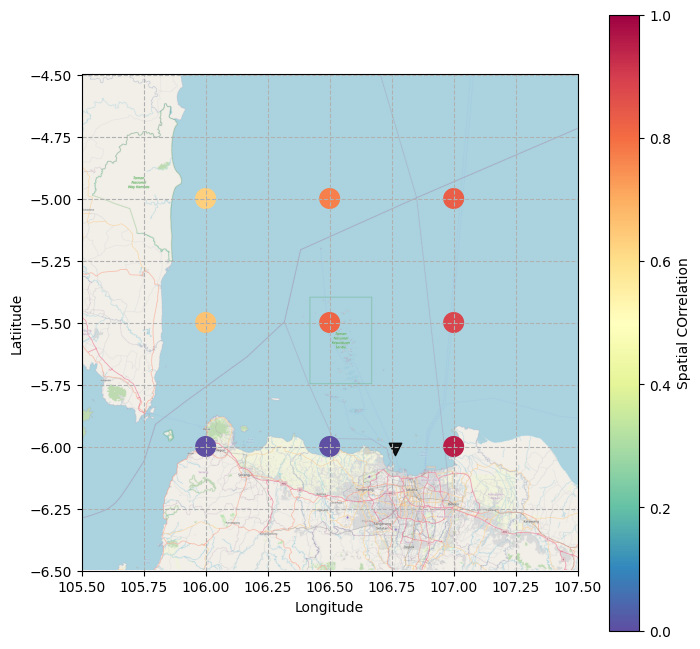

In [ ]:
wp_plotting(wave_point.Longitude, wave_point.Latitude, wave_point.CC)

###### all wave point Transformer

In [ ]:
#Data Setup
location_input = np.loadtxt("Global Point.txt", dtype=str)

#Train Data Setup (8yr)
train_data_all = np.transpose(np.array(data_processing('2011', '2016', location_input)), (1, 0, 2))
target_train_all = np.array(df_swan['Hs'].loc['2011':'2016'].tolist())
print("8 Years Train Data Setup Complete...")

#Evaluation Data Setup
val_data = np.transpose(np.array(data_processing('2019', '2019', location_input)), (1, 0, 2))
target_val = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

8 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


Epoch 1/200
274/274 [==============================] - 26s 47ms/step - loss: 0.0160 - val_loss: 0.0038
Epoch 2/200
274/274 [==============================] - 5s 17ms/step - loss: 0.0109 - val_loss: 0.0034
Epoch 3/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0086 - val_loss: 0.0031
Epoch 4/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0069 - val_loss: 0.0028
Epoch 5/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 6/200
274/274 [==============================] - 4s 16ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 7/200
274/274 [==============================] - 4s 14ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 8/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 9/200
274/274 [==============================] - 5s 18ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 10/200
274/274 [==============================] - 4s 16ms/step - loss: 0.00

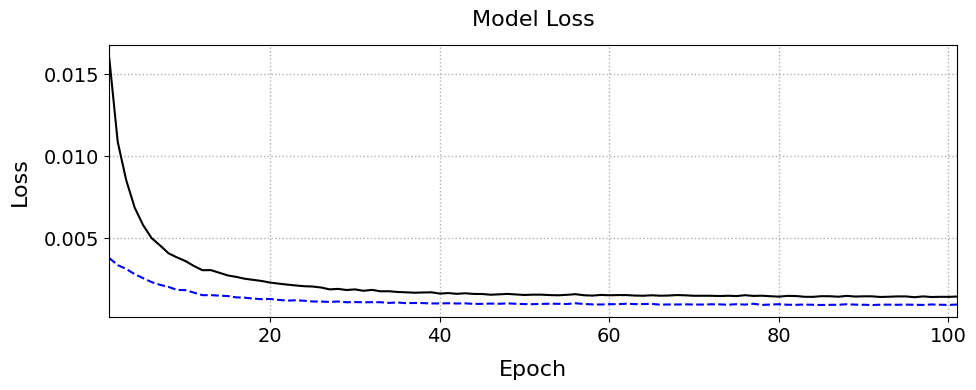

In [ ]:
# 8 years data training
model_all, modelhist_all, comp_time_all = transformer_model(train_data_all, target_train_all, val_data, target_val)
plotLossHistory(modelhist_all.history['loss'],modelhist_all.history['val_loss'],'Loss.png')

In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model_all.save_weights('Model_9p_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_9p_History.npy',modelhist_all.history)
#melakukan save waktu lama pelatihan model
np.save('Model_9p_Time.npy', comp_time_all)

In [ ]:
comp_time_all

508.9568569840003

Test Data Setup Complete...
4/4 [==============================] - 0s 7ms/step
Testing
Correlation Coefficient value is  0.969
RMSE value is  0.04
MAPE value is  10.973
4/4 [==============================] - 0s 6ms/step


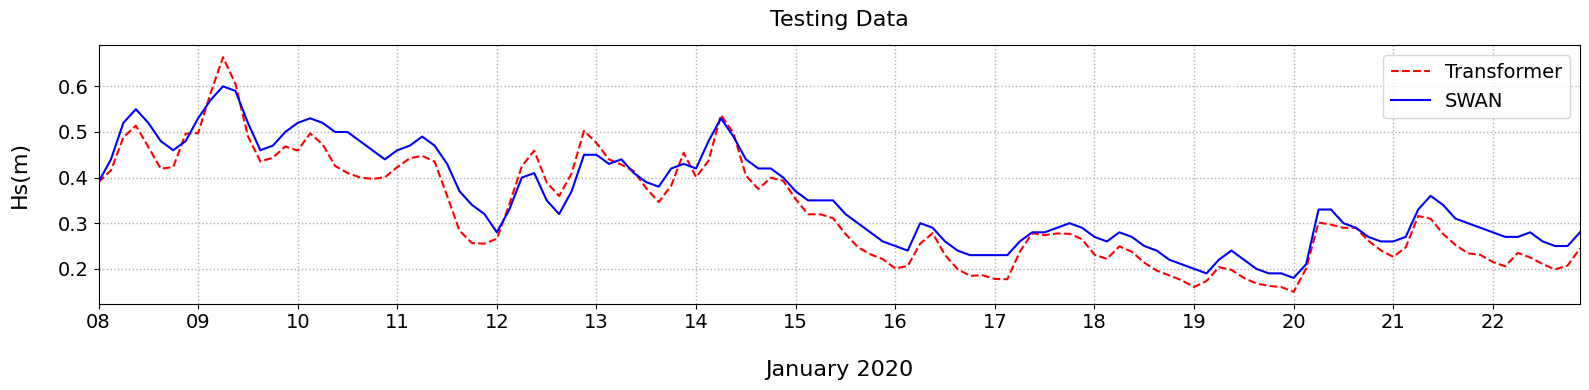

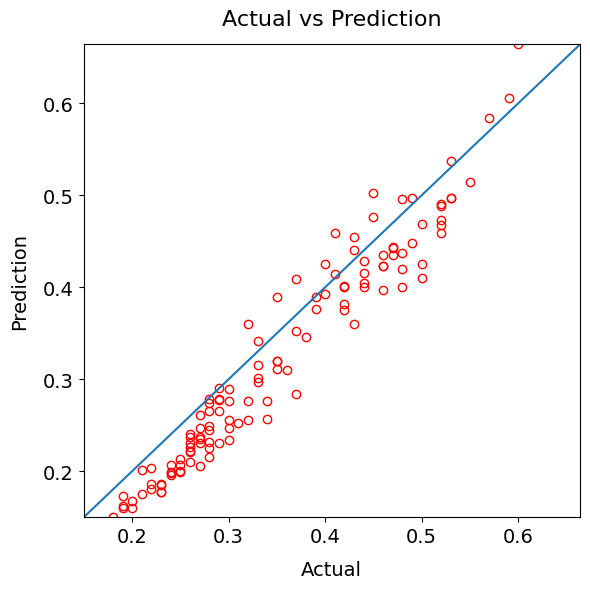

In [ ]:
#Test Data Setup
test_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input)), (1, 0, 2))
target_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")

# years data testing
model_testing(model_all, test_data, target_test, '2020-01-08', '2020-01-22', 'Testing-14d-Data_9p.png', 'Testing-14d-ScatterData_9p.png')

##### CC > 0.80 (4 wave point)

###### 4 wave point plot

In [ ]:
wave_point_4 = wave_point.loc[wave_point.CC > 0.8].reset_index()
wave_point_4

,index,Longitude,Latitude,CC
0,4,106.5,-5.5,0.82
1,6,107.0,-5.0,0.83
2,7,107.0,-5.5,0.88
3,8,107.0,-6.0,0.95


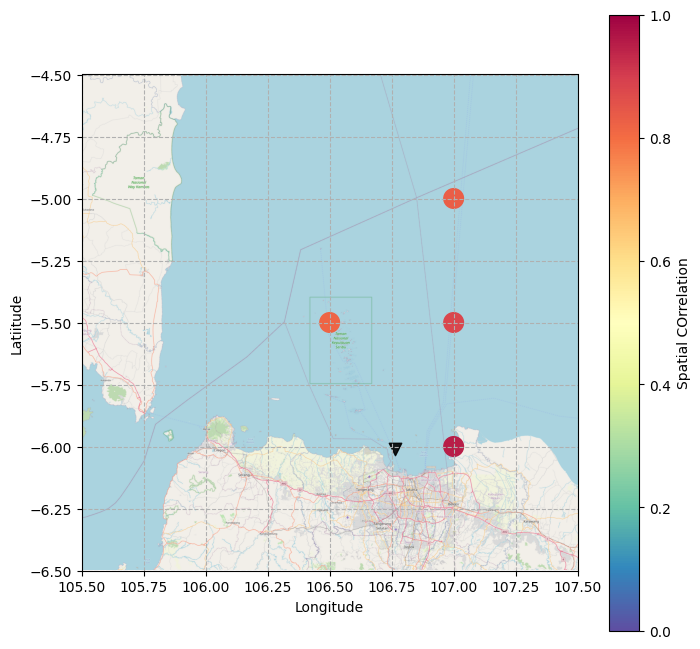

In [ ]:
wp_plotting(wave_point_4.Longitude, wave_point_4.Latitude, wave_point_4.CC)

###### 4 point Transformer

In [ ]:
#4 wave point, Data Setup
location_input_4 = get_location(wave_point_4)

#Train Data Setup (8yr)
train8_data_4 = np.transpose(np.array(data_processing('2011', '2016', location_input_4)), (1, 0, 2))
target8_train_4 = np.array(df_swan['Hs'].loc['2011':'2016'].tolist())
print("8 Years Train Data Setup Complete...")

#Evaluation Data Setup
val_data_4 = np.transpose(np.array(data_processing('2019', '2019', location_input_4)), (1, 0, 2))
target_val_4 = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

4
8 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


Epoch 1/200
274/274 [==============================] - 24s 24ms/step - loss: 0.0247 - val_loss: 0.0041
Epoch 2/200
274/274 [==============================] - 6s 21ms/step - loss: 0.0114 - val_loss: 0.0034
Epoch 3/200
274/274 [==============================] - 8s 30ms/step - loss: 0.0095 - val_loss: 0.0034
Epoch 4/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0088 - val_loss: 0.0032
Epoch 5/200
274/274 [==============================] - 6s 21ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 6/200
274/274 [==============================] - 4s 15ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 7/200
274/274 [==============================] - 4s 14ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 8/200
274/274 [==============================] - 7s 25ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 9/200
274/274 [==============================] - 7s 24ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 10/200
274/274 [==============================] - 7s 25ms/step - loss: 0.00

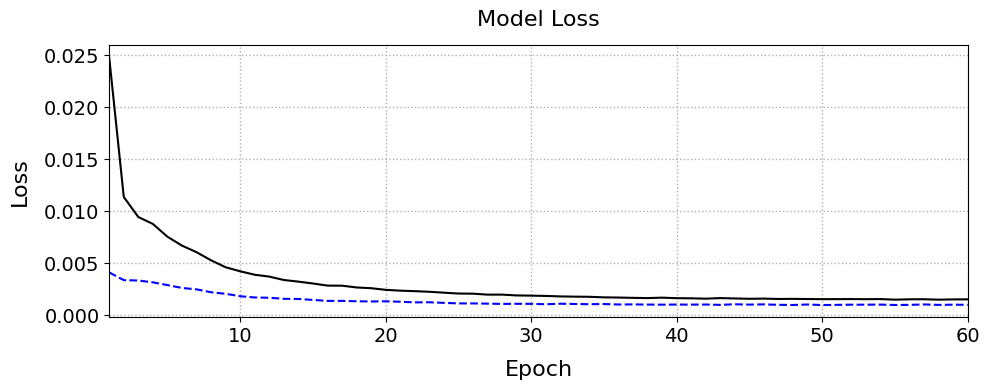

In [ ]:
# 4 wave point, 8 years data training
model_4, modelhist_4, comp_time_4 = transformer_model(train8_data_4, target8_train_4, val_data_4, target_val_4)
plotLossHistory(modelhist_4.history['loss'],modelhist_4.history['val_loss'],'Loss.png')

In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model_4.save_weights('Model_4p_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_4p_History.npy',modelhist_4.history)
#melakukan save waktu lama pelatihan model
np.save('Model_4p_Time.npy', comp_time_4)

In [ ]:
comp_time_4

329.13745566000034

Test Data Setup Complete...
4/4 [==============================] - 0s 6ms/step
Testing
Correlation Coefficient value is  0.971
RMSE value is  0.045
MAPE value is  12.522
4/4 [==============================] - 0s 4ms/step


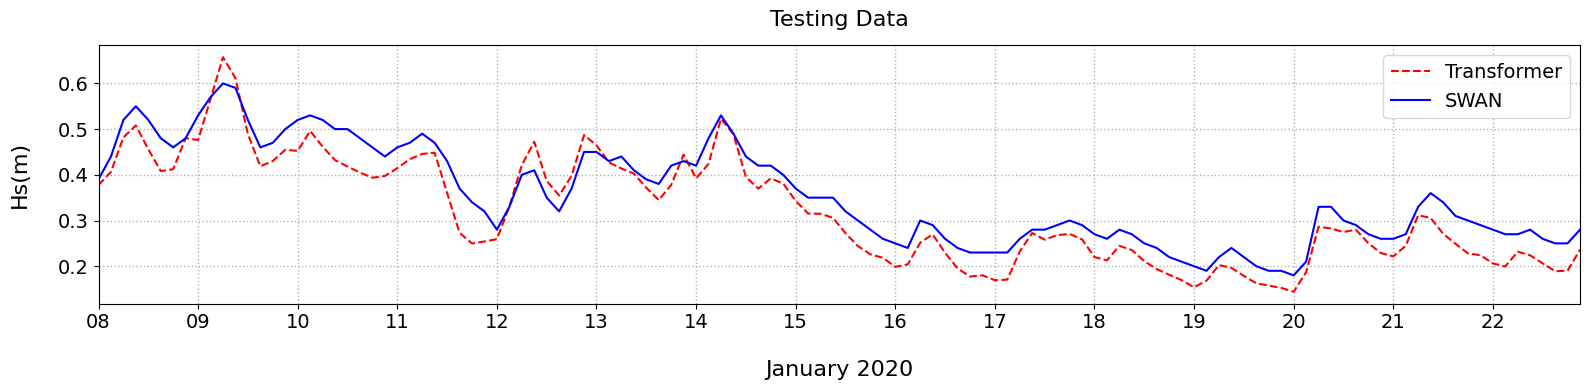

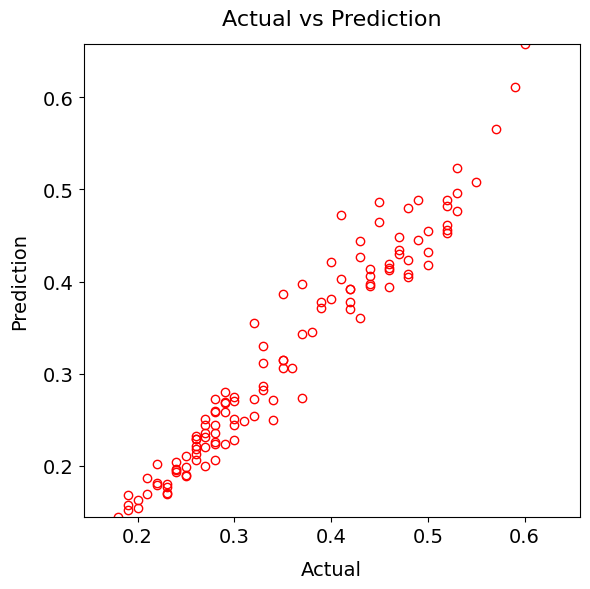

In [ ]:
#Test Data Setup
test_data_4 = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input_4)), (1, 0, 2))
target_test_4 = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")
#8 4 wave point, 8 years data testing 14 days prediction
model_testing(model_4, test_data_4, target_test_4, '2020-01-08', '2020-01-22', 'Testing-14d-Data_4p.png', 'Testing-14d-ScatterData_4p.png')

##### Conclusion

there are not much difference based on the comparison of each spatial correlation downscaling performances, we use data with spacial corellation of CC > 0.80 to perform more comparison tests

#### Training Data Length

##### 8 Years

###### 8 Years Data Setup

In [ ]:
#8 years Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (8yr)
train8_data = np.transpose(np.array(data_processing('2011', '2018', location_input)), (1, 0, 2))
target8_train = np.array(df_swan['Hs'].loc['2011':'2018'].tolist())
print("8 Years Train Data Setup Complete...")

#Evaluation Data Setup
val8_data = np.transpose(np.array(data_processing('2019', '2019', location_input)), (1, 0, 2))
target8_val = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

4
8 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


###### 8 Years Data Training

Epoch 1/200
366/366 [==============================] - 22s 21ms/step - loss: 0.0133 - val_loss: 0.0033
Epoch 2/200
366/366 [==============================] - 6s 17ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 3/200
366/366 [==============================] - 7s 19ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 4/200
366/366 [==============================] - 6s 18ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 5/200
366/366 [==============================] - 7s 19ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 6/200
366/366 [==============================] - 6s 18ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 7/200
366/366 [==============================] - 8s 21ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 8/200
366/366 [==============================] - 6s 18ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/200
366/366 [==============================] - 7s 19ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 10/200
366/366 [==============================] - 7s 18ms/step - loss: 0.00

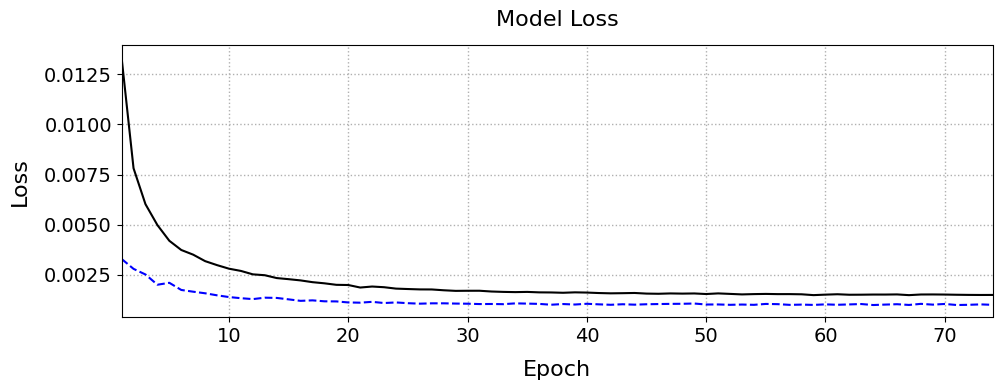

In [ ]:
# 8 years data training
model8, model8hist, comp_time8 = transformer_model(train8_data, target8_train, val8_data, target8_val)
plotLossHistory(model8hist.history['loss'],model8hist.history['val_loss'],'Loss.png')

In [ ]:
from sklearn import metrics

pred8 = model8.predict(test8_data)
score8 = np.sqrt(metrics.mean_squared_error(pred8,target8_test))
print("Score (RMSE): {}".format(score8))

8/8 [==============================] - 0s 4ms/step
Score (RMSE): 0.04796603214051028


In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model8.save_weights('Model_8yr_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_8yr_History.npy',model8hist.history)
#melakukan save waktu lama pelatihan model
np.save('Model_8yr_Time.npy', comp_time8)

In [ ]:
comp_time8

520.1835891119999

###### 8 Years Data Testing

Test Data Setup Complete...
4/4 [==============================] - 0s 7ms/step
Testing
Correlation Coefficient value is  0.972
RMSE value is  0.045
MAPE value is  12.707
4/4 [==============================] - 0s 7ms/step


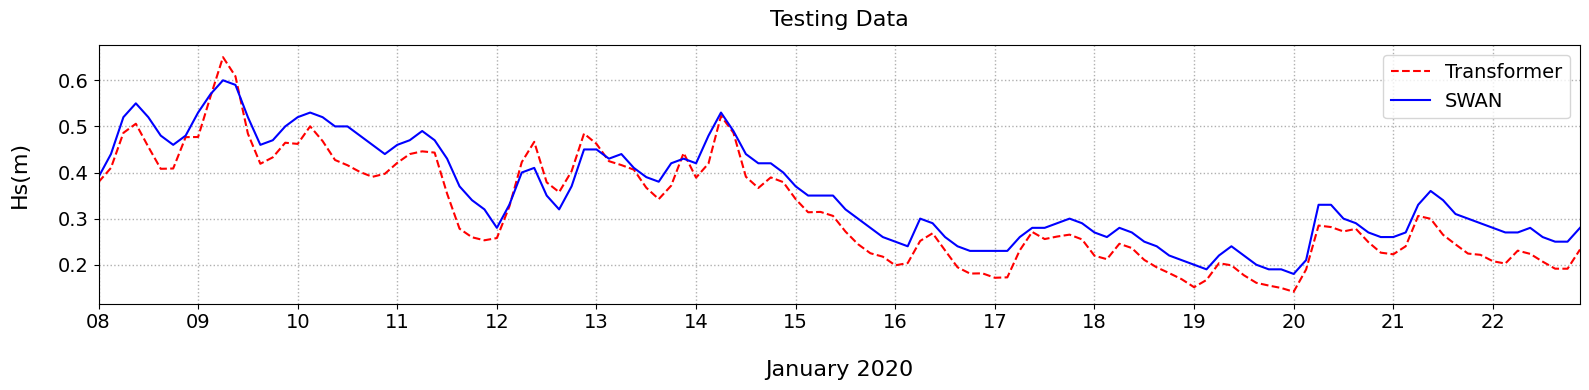

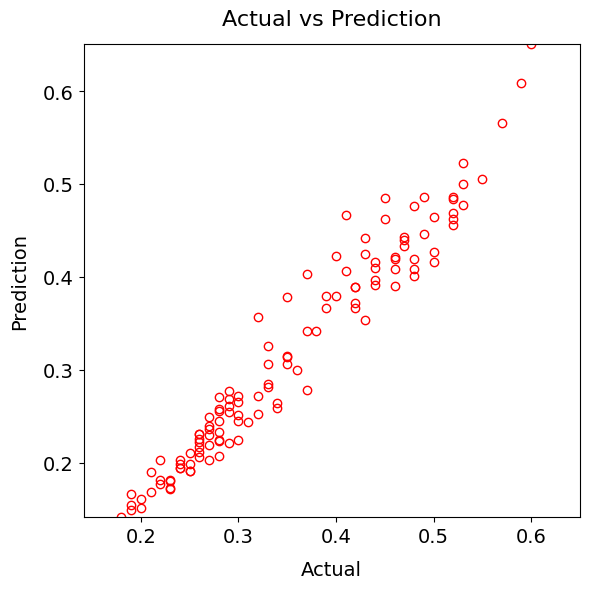

In [ ]:
#Test Data Setup
test8_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input)), (1, 0, 2))
target8_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")

model_testing(model8, test8_data, target8_test, '2020-01-08', '2020-01-22', 'Testing-14d-Data_8y.png', 'Testing-14d-ScatterData_8y.png')

##### 6 Years

###### 6 Years Training Data Setup

In [ ]:
#6 years Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (6yr)
train6_data = np.transpose(np.array(data_processing('2013', '2018', location_input)), (1, 0, 2))
target6_train = np.array(df_swan['Hs'].loc['2013':'2018'].tolist())
print("6 Years Train Data Setup Complete...")

#Evaluation Data Setup
val6_data = np.transpose(np.array(data_processing('2019', '2019', location_input)), (1, 0, 2))
target6_val = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

4
6 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


###### 6 Years Data Training

Epoch 1/200
274/274 [==============================] - 19s 20ms/step - loss: 0.1050 - val_loss: 0.0380
Epoch 2/200
274/274 [==============================] - 5s 20ms/step - loss: 0.0232 - val_loss: 0.0049
Epoch 3/200
274/274 [==============================] - 5s 18ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 4/200
274/274 [==============================] - 5s 17ms/step - loss: 0.0112 - val_loss: 0.0041
Epoch 5/200
274/274 [==============================] - 6s 22ms/step - loss: 0.0103 - val_loss: 0.0038
Epoch 6/200
274/274 [==============================] - 5s 19ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 7/200
274/274 [==============================] - 6s 21ms/step - loss: 0.0090 - val_loss: 0.0035
Epoch 8/200
274/274 [==============================] - 5s 19ms/step - loss: 0.0083 - val_loss: 0.0033
Epoch 9/200
274/274 [==============================] - 5s 18ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 10/200
274/274 [==============================] - 6s 22ms/step - loss: 0.00

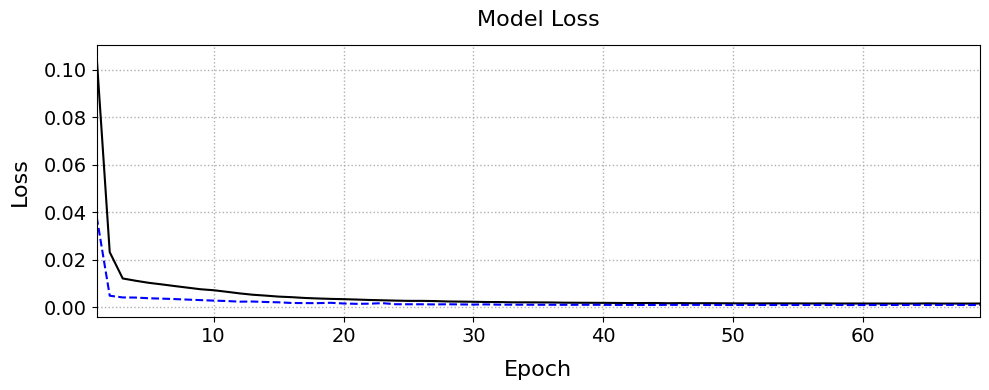

In [ ]:
# 6 years data training
model6, model6hist, comp_time6 = transformer_model(train6_data, target6_train, val6_data, target6_val)
plotLossHistory(model6hist.history['loss'],model6hist.history['val_loss'],'Loss.png')

In [ ]:
from sklearn import metrics

pred6 = model6.predict(test6_data)
score6 = np.sqrt(metrics.mean_squared_error(pred6,target6_test))
print("Score (RMSE): {}".format(score6))

8/8 [==============================] - 0s 4ms/step
Score (RMSE): 0.04635716098406369


In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model6.save_weights('Model_6yr_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_6yr_History.npy',model6hist.history)
#melakukan save waktu lama pelatihan model
np.save('Model_6yr_Time.npy', comp_time6)

In [ ]:
comp_time6

448.6047157040002

###### 6 Years Data Testing

Test Data Setup Complete...
4/4 [==============================] - 0s 4ms/step
Testing
Correlation Coefficient value is  0.972
RMSE value is  0.044
MAPE value is  12.34
4/4 [==============================] - 0s 4ms/step


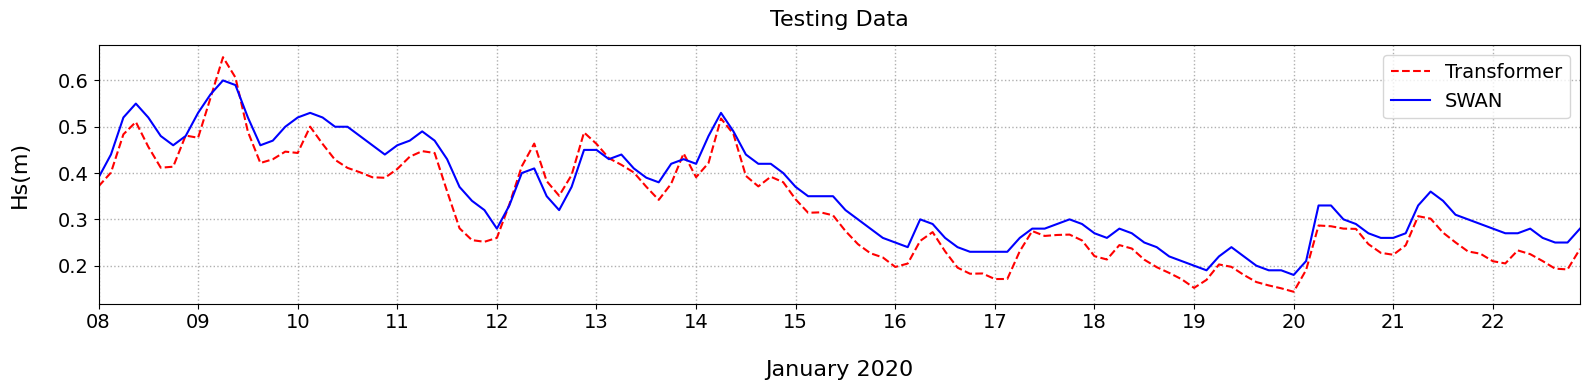

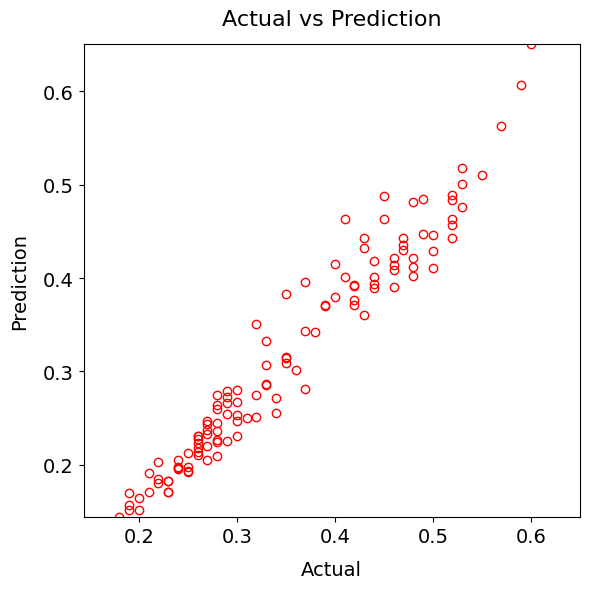

In [ ]:
#Test Data Setup
test6_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input)), (1, 0, 2))
target6_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")

model_testing(model6, test6_data, target6_test, '2020-01-08', '2020-01-22', 'Testing-14d-Data_6y.png', 'Testing-14d-ScatterData_6y.png')

##### 4 Years

###### 4 Years Data Setup

In [ ]:
#4 years Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (4yr)
train4_data = np.transpose(np.array(data_processing('2015', '2018', location_input)), (1, 0, 2))
target4_train = np.array(df_swan['Hs'].loc['2011':'2014'].tolist())
print("4 Years Train Data Setup Complete...")

#Evaluation Data Setup
val4_data = np.transpose(np.array(data_processing('2019', '2019', location_input)), (1, 0, 2))
target4_val = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

4
4 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


###### 4 Years Data Training

Epoch 1/200
183/183 [==============================] - 25s 25ms/step - loss: 0.0467 - val_loss: 0.0059
Epoch 2/200
183/183 [==============================] - 4s 20ms/step - loss: 0.0372 - val_loss: 0.0075
Epoch 3/200
183/183 [==============================] - 3s 18ms/step - loss: 0.0320 - val_loss: 0.0103
Epoch 4/200
183/183 [==============================] - 3s 18ms/step - loss: 0.0285 - val_loss: 0.0137
Epoch 5/200
183/183 [==============================] - 4s 23ms/step - loss: 0.0278 - val_loss: 0.0133
Epoch 6/200
183/183 [==============================] - 3s 19ms/step - loss: 0.0271 - val_loss: 0.0136
Epoch 7/200
183/183 [==============================] - 3s 18ms/step - loss: 0.0269 - val_loss: 0.0140
Epoch 8/200
183/183 [==============================] - 3s 19ms/step - loss: 0.0265 - val_loss: 0.0139
Epoch 9/200
183/183 [==============================] - 4s 24ms/step - loss: 0.0261 - val_loss: 0.0139
Epoch 10/200
183/183 [==============================] - 3s 18ms/step - loss: 0.02

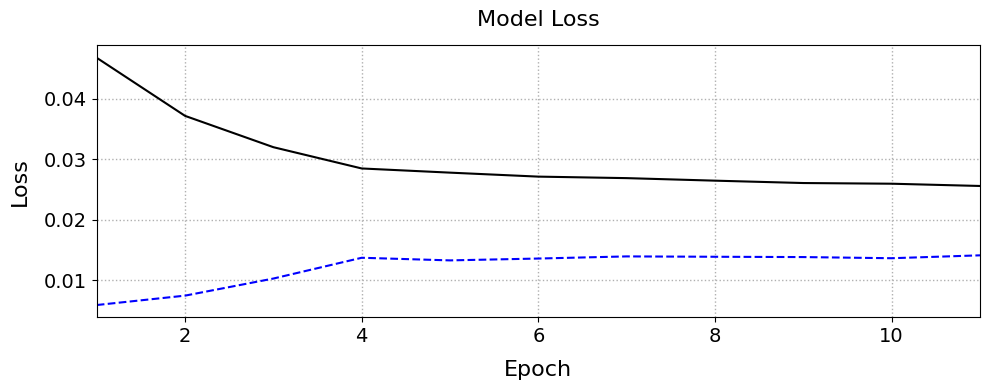

In [ ]:
# 4 years data training
model4, model4hist, comp_time4 = transformer_model(train4_data, target4_train, val4_data, target4_val)
plotLossHistory(model4hist.history['loss'],model4hist.history['val_loss'],'Loss.png')

In [ ]:
from sklearn import metrics

pred4 = model4.predict(test4_data)
score4 = np.sqrt(metrics.mean_squared_error(pred4,target4_test))
print("Score (RMSE): {}".format(score4))

8/8 [==============================] - 1s 4ms/step
Score (RMSE): 0.12932501052303502


In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model4.save_weights('Model_4yr_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_4yr_History.npy',model4hist.history)
#melakukan save waktu lama pelatihan model
np.save('Model_4yr_Time.npy', comp_time4)

In [ ]:
comp_time_4

329.13745566000034

###### 4 Years DataTesting

Test Data Setup Complete...
4/4 [==============================] - 0s 5ms/step
Testing
Correlation Coefficient value is  0.946
RMSE value is  0.111
MAPE value is  27.616
4/4 [==============================] - 0s 5ms/step


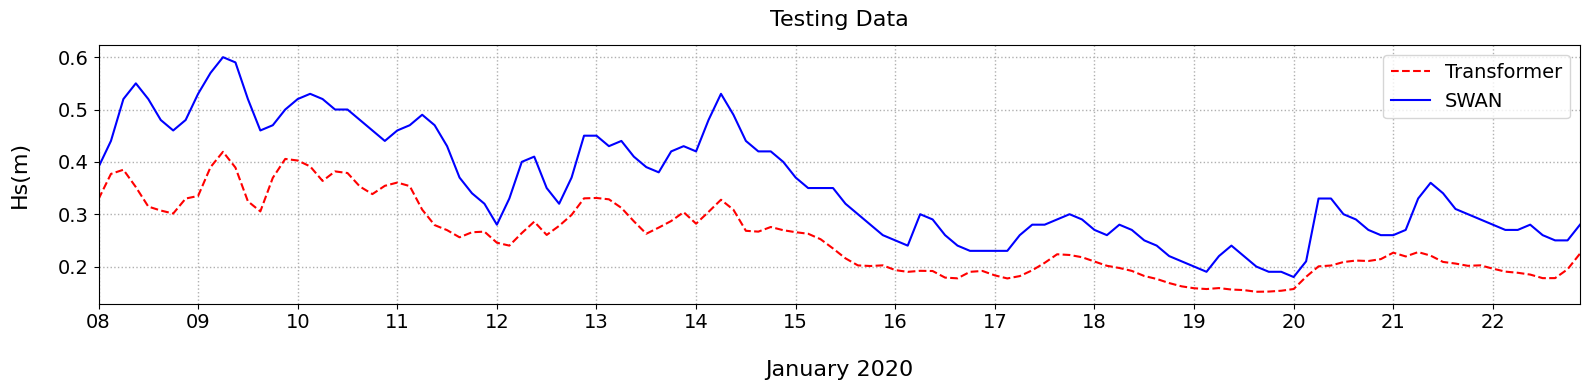

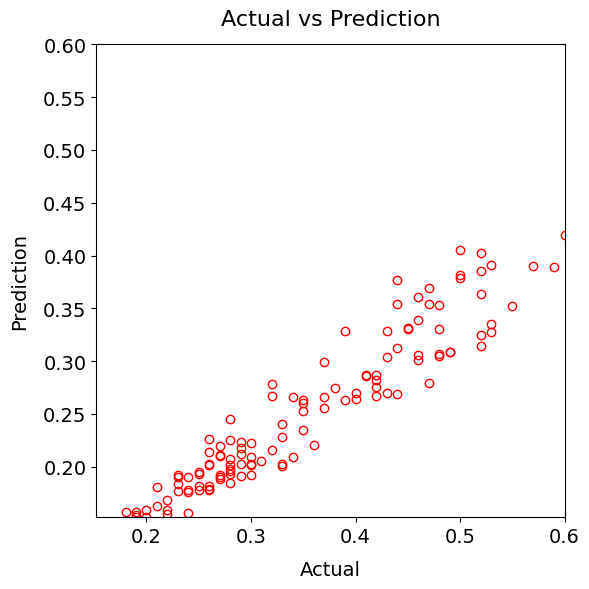

In [ ]:
#Test Data Setup
test4_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input)), (1, 0, 2))
target4_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")

model_testing(model4, test4_data, target4_test, '2020-01-08', '2020-01-22', 'Testing-14d-Data_4y.png', 'Testing-14d-ScatterData_4y.png')

##### 2 years

###### 2 Years Data Setup

In [ ]:
#2 years Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (2yr)
train2_data = np.transpose(np.array(data_processing('2017', '2018', location_input)), (1, 0, 2))
target2_train = np.array(df_swan['Hs'].loc['2017':'2018'].tolist())
print("2 Years Train Data Setup Complete...")

#Evaluation Data Setup
val2_data = np.transpose(np.array(data_processing('2019', '2019', location_input)), (1, 0, 2))
target2_val = np.array(df_swan['Hs'].loc['2019'].tolist())
print("Evaluation Data Setup Complete...")

4
2 Years Train Data Setup Complete...
Evaluation Data Setup Complete...
Test Data Setup Complete...


###### 2 Years Data Training

Epoch 1/200
92/92 [==============================] - 19s 25ms/step - loss: 0.0632 - val_loss: 0.0121
Epoch 2/200
92/92 [==============================] - 2s 20ms/step - loss: 0.0241 - val_loss: 0.0060
Epoch 3/200
92/92 [==============================] - 2s 21ms/step - loss: 0.0171 - val_loss: 0.0034
Epoch 4/200
92/92 [==============================] - 2s 19ms/step - loss: 0.0143 - val_loss: 0.0032
Epoch 5/200
92/92 [==============================] - 2s 26ms/step - loss: 0.0124 - val_loss: 0.0034
Epoch 6/200
92/92 [==============================] - 2s 24ms/step - loss: 0.0110 - val_loss: 0.0029
Epoch 7/200
92/92 [==============================] - 2s 20ms/step - loss: 0.0104 - val_loss: 0.0032
Epoch 8/200
92/92 [==============================] - 2s 21ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 9/200
92/92 [==============================] - 2s 20ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 10/200
92/92 [==============================] - 2s 21ms/step - loss: 0.0090 - val_loss: 0.002

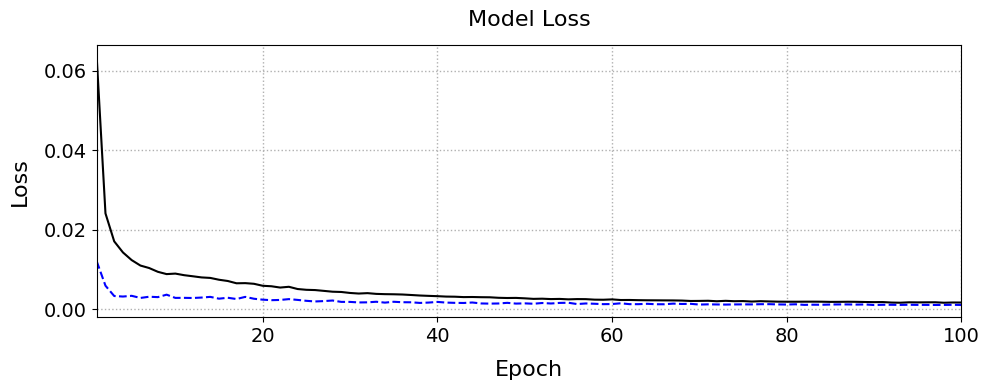

In [ ]:
# 2 years data training
model2, model2hist, comp_time2 = transformer_model(train2_data, target2_train, val2_data, target2_val)
plotLossHistory(model2hist.history['loss'],model2hist.history['val_loss'],'Loss.png')

In [ ]:
from sklearn import metrics

pred2 = model2.predict(test2_data)
score2 = np.sqrt(metrics.mean_squared_error(pred2,target2_test))
print("Score (RMSE): {}".format(score2))

8/8 [==============================] - 1s 6ms/step
Score (RMSE): 0.052331915533618475


In [ ]:
#melkakukan value atau hasil yang didapatkan dari learning process
model2.save_weights('Model_2yr_Weight.h5')
#melakukan save histori pelatihan model
np.save('Model_2yr_History.npy',model2hist.history)
#melakukan save waktu lama pelatihan model
np.save('Model_2yr_Time.npy', comp_time2)

In [ ]:
comp_time2

269.1153536660004

###### 2 Years Data Testing

Test Data Setup Complete...
4/4 [==============================] - 0s 5ms/step
Testing
Correlation Coefficient value is  0.975
RMSE value is  0.049
MAPE value is  13.417
4/4 [==============================] - 0s 4ms/step


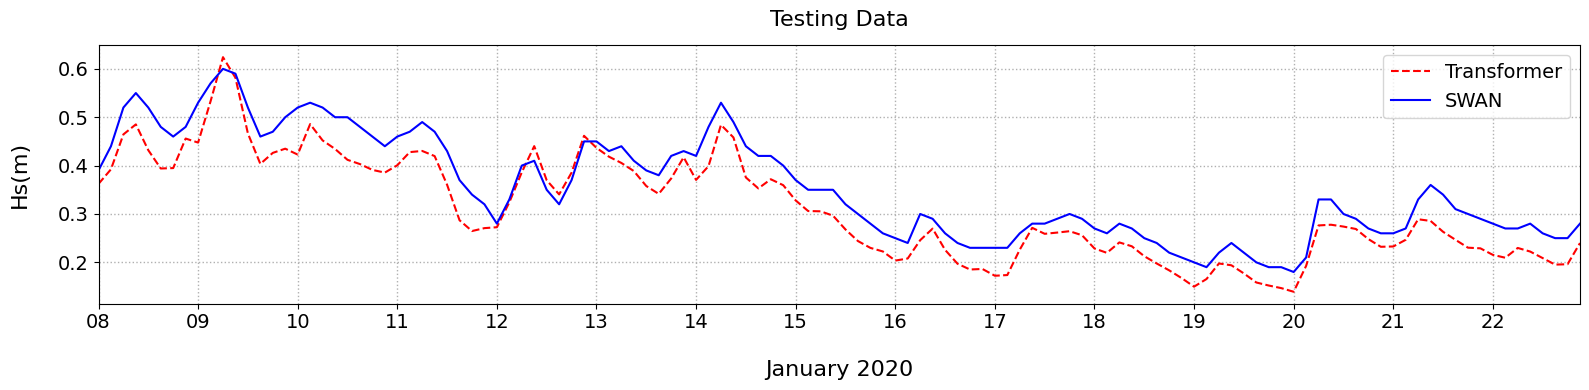

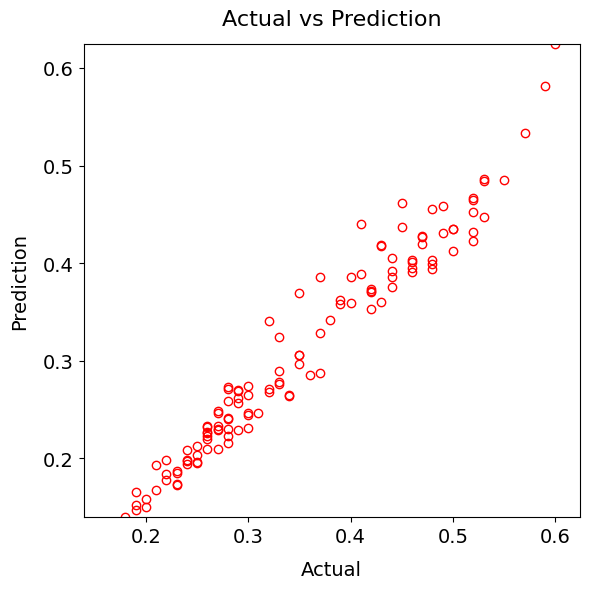

In [ ]:
#Test Data Setup
test2_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-22', location_input)), (1, 0, 2))
target2_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-22'].tolist())
print("Test Data Setup Complete...")

model_testing(model2, test2_data, target2_test, '2020-01-08', '2020-01-22', 'Testing-14d-Data_2y.png', 'Testing-14d-ScatterData_2y.png')

##### conclusion

6 years have best result

#### prediction Length

##### 1 days prediction

In [ ]:
#Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (8yr)
test_data_1 = np.transpose(np.array(data_processing('2020-01-20', '2020-01-20', location_input)), (1, 0, 2))
target_test_1 = np.array(df_swan['Hs'].loc['2020-01-20':'2020-01-20'].tolist())
print("1 Days Test Data Setup Complete...")

4
1 Days Test Data Setup Complete...


1/1 [==============================] - 0s 43ms/step
Testing
Correlation Coefficient value is  0.973
RMSE value is  0.031
MAPE value is  10.933
1/1 [==============================] - 0s 30ms/step


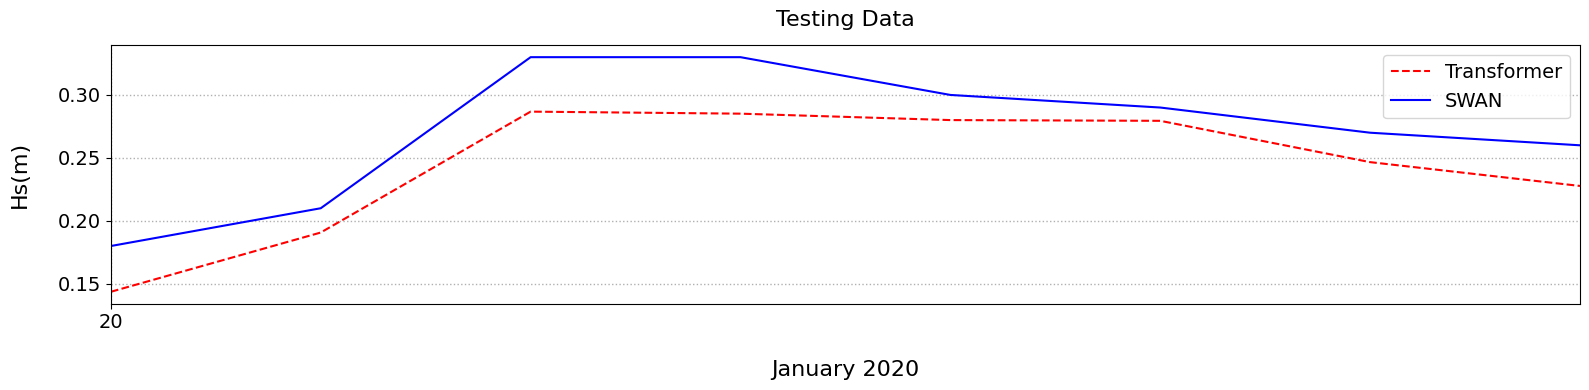

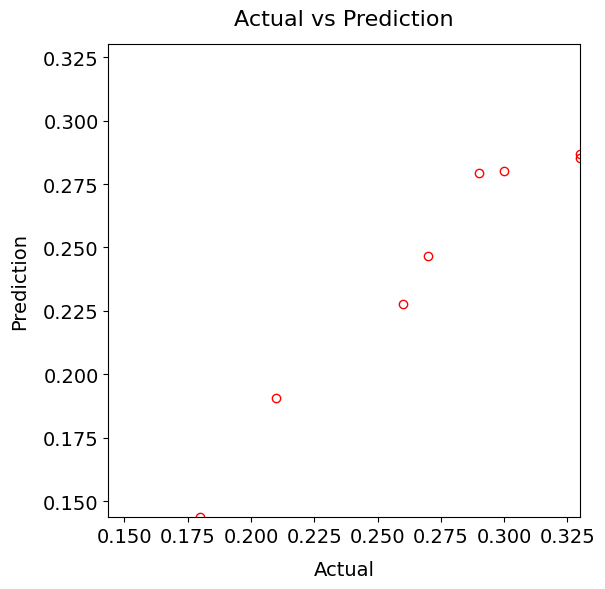

In [ ]:
model_testing(model6, test_data_1, target_test_1, '2020-01-20', '2020-01-20', 'Testing-1d-Data_6y.png', 'Testing-1d-ScatterData_6y.png')

##### 3 days prediction

In [ ]:
#Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (8yr)
test_data_3 = np.transpose(np.array(data_processing('2020-01-20', '2020-01-22', location_input)), (1, 0, 2))
target_test_3 = np.array(df_swan['Hs'].loc['2020-01-20':'2020-01-22'].tolist())
print("3 Days Test Data Setup Complete...")

4
3 Days Test Data Setup Complete...


1/1 [==============================] - 0s 42ms/step
Testing
Correlation Coefficient value is  0.899
RMSE value is  0.048
MAPE value is  15.932
1/1 [==============================] - 0s 33ms/step


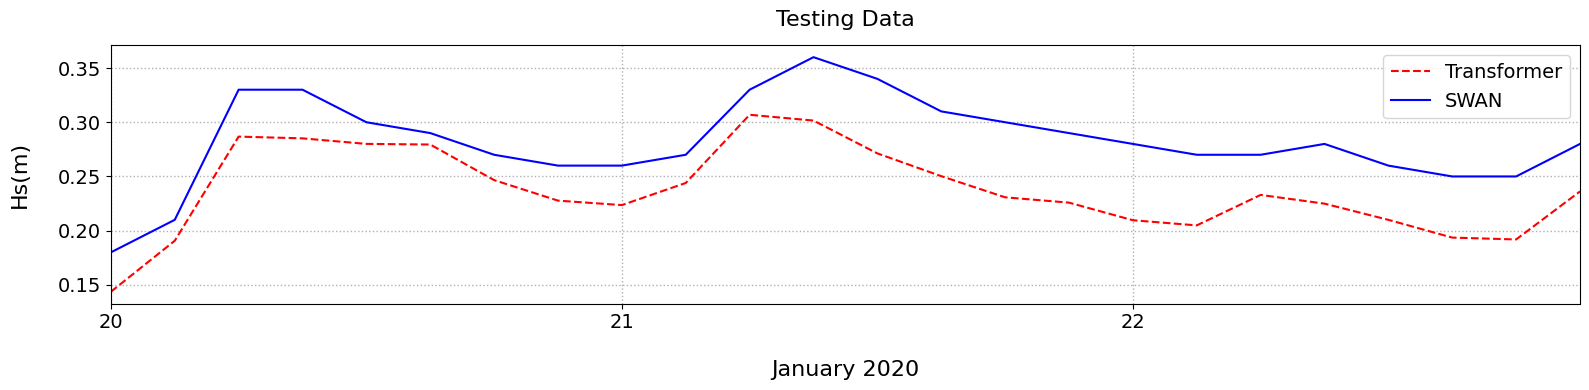

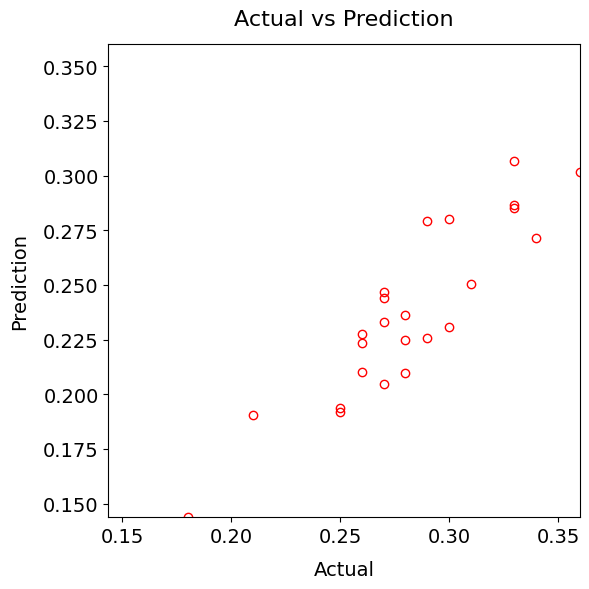

In [ ]:
model_testing(model6, test_data_3, target_test_3, '2020-01-20', '2020-01-22', 'Testing-3d-Data_6y.png', 'Testing-3d-ScatterData_6y.png')

##### 5 days prediction

In [ ]:
#Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (8yr)
test_data_5 = np.transpose(np.array(data_processing('2020-01-20', '2020-01-24', location_input)), (1, 0, 2))
target_test_5 = np.array(df_swan['Hs'].loc['2020-01-20':'2020-01-24'].tolist())
print("5 Days Test Data Setup Complete...")

4
5 Days Test Data Setup Complete...


2/2 [==============================] - 0s 8ms/step
Testing
Correlation Coefficient value is  0.913
RMSE value is  0.046
MAPE value is  13.257
2/2 [==============================] - 0s 7ms/step


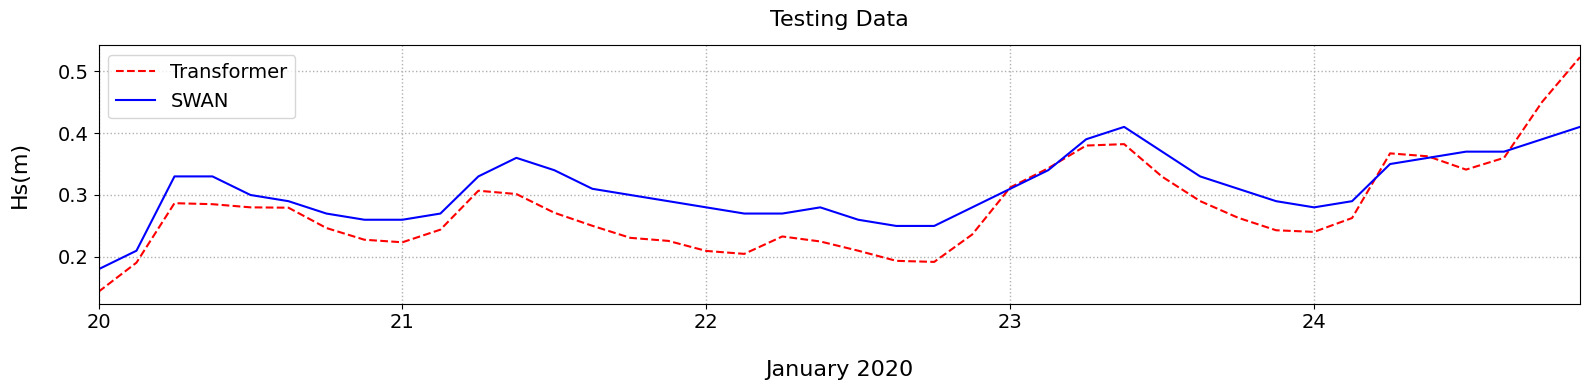

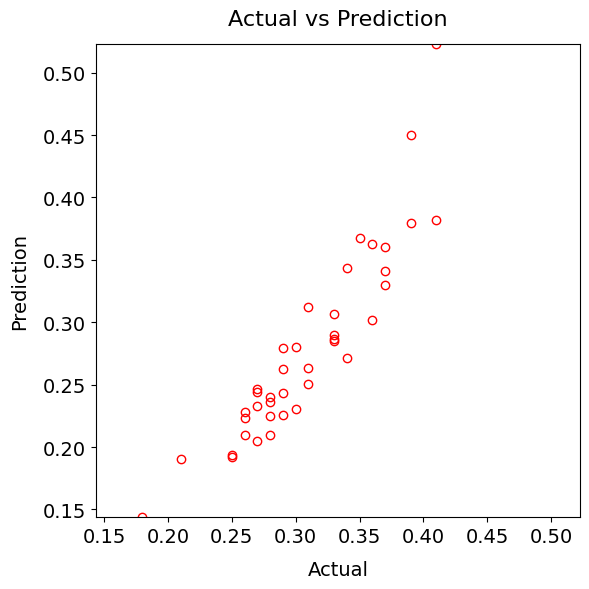

In [ ]:
model_testing(model6, test_data_5, target_test_5, '2020-01-20', '2020-01-24', 'Testing-5d-Data_6y.png', 'Testing-5d-ScatterData_6y.png')

##### 7 days prediction

In [ ]:
#Data Setup
location_input = get_location(wave_point_4)

#Train Data Setup (8yr)
test_data_7 = np.transpose(np.array(data_processing('2020-01-20', '2020-01-26', location_input)), (1, 0, 2))
target_test_7 = np.array(df_swan['Hs'].loc['2020-01-20':'2020-01-26'].tolist())
print("7 Days Test Data Setup Complete...")

4
7 Days Test Data Setup Complete...


2/2 [==============================] - 0s 8ms/step
Testing
Correlation Coefficient value is  0.928
RMSE value is  0.047
MAPE value is  12.876
2/2 [==============================] - 0s 7ms/step


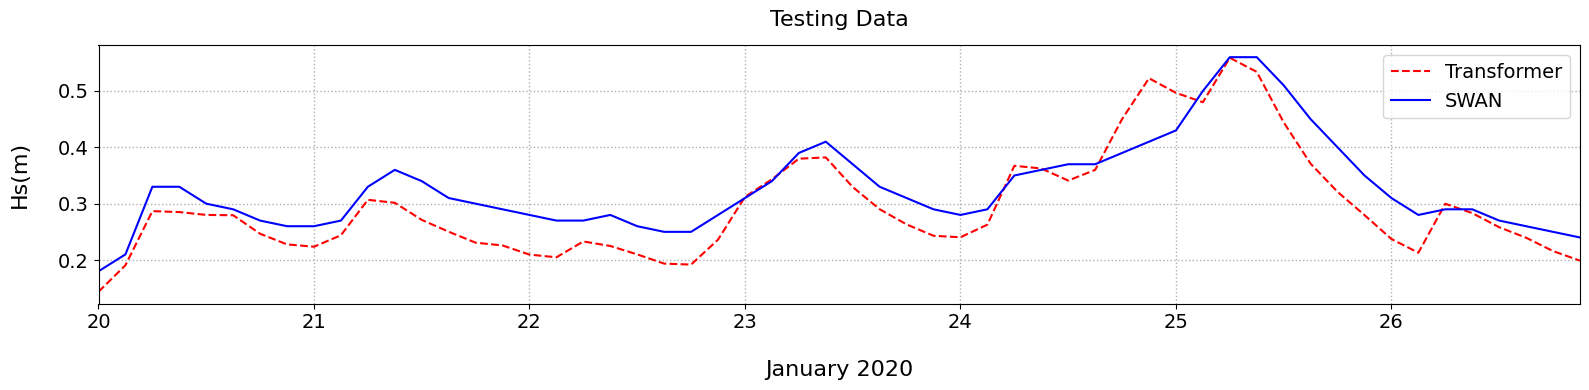

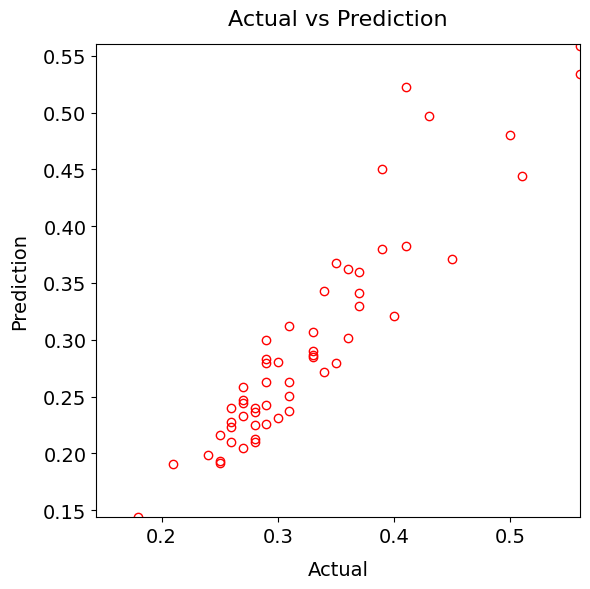

In [ ]:
model_testing(model6, test_data_7, target_test_7, '2020-01-20', '2020-01-26', 'Testing-7d-Data_6y.png', 'Testing-7d-ScatterData_6y.png')

##### Conclusion

1 day prediction is almost a perfect prediction and at first the longer the prediction length are, the lower it’s performances but then after day 14 the performance rises up again.

### Vs BiLSTM

#### Transformer

###### Data Setup

In [ ]:
#Test Data Setup
test_data = np.transpose(np.array(data_processing('2020-01-08', '2020-01-21', location_input)), (1, 0, 2))
target_test = np.array(df_swan['Hs'].loc['2020-01-08':'2020-01-21'].tolist())
print("Test Data Setup Complete...")

Test Data Setup Complete...


4/4 [==============================] - 0s 8ms/step
Testing
Correlation Coefficient value is  0.971
RMSE value is  0.043
MAPE value is  11.763
4/4 [==============================] - 0s 5ms/step


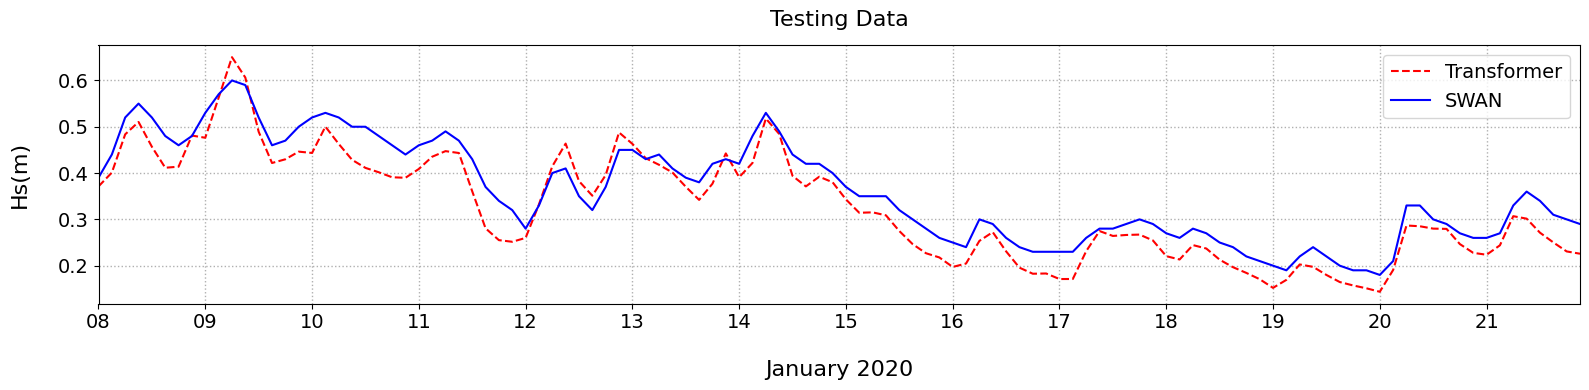

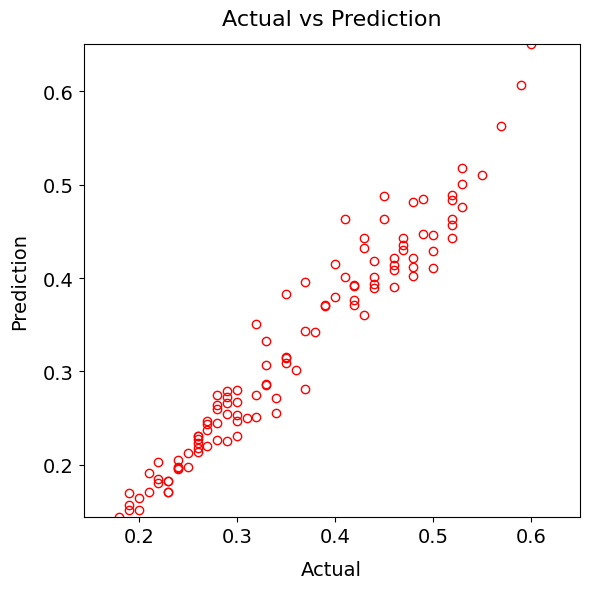

In [ ]:
# 8 years data testing
model_testing(model6, test_data, target_test, '2020-01-08', '2020-01-21', 'Training Data versus2.png', 'Trainind ScatterData versus2.png')